<h1 style="color:blue"> Bayesian Statistics and Probabilistic Programming</h1>

<h1 style="color:blue"> Spring 2022 - Homework 01</h1>

<h3 style="color:blue">2022-04-04</h3>

## Iker Honorato, David Catalan, Pau Satorra

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exponential}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

<h1 style="color:blue">Instructions</h1>

### Submissions: 

By **groups** of _about_ three students (meaning: two is OK, four is not advisable but possible. Individual homeworks 
will also be accepted but collaborative work is preferable). 

Please send me an **email** with the team members names as soon as you have formed it.

Only **one copy** of each group's work must be uploaded (by any member)

### Format: 

A Jupyter or R Markdown **notebook,** with a **header** clearly stating the names of all contributors. 

### Documentation: 

Comments **in code cells** (e.g., meaning of variables, parameters, purpose of functions) are necessary but not sufficient.

You are expected to give full explanations of steps taken in your solution (in **Markdown cells**), as well as discussion of results and their meaning.

Do not drear being too verbose or too elementary.

### External sources

Getting inspiration from any book, document, blog, wep page, even mimicking solutions given in there, is **allowed and encouraged,** provided you give a **proper reference,**
understand every such material, and explain it in you own words, even more exhaustively.

Dare not **copy/paste literally.** I do detect it, believe me, even with a missing source reference. Bleak consequences.

### Deadline:

Completed assignments are due on Tuesday, April 19. They are to be uploaded to the Virtual Campus.

<h1 style="color:blue">01 - Stan version of a conjugate prior problem</h1>

<h2 style="color:blue">Modelling Earthquake Waiting Times</h2>

Consider the problem in `Exponential.02.Earthquake` (notebook in 2022-03-28 folder), where the goal is to study earthquake waiting times.

Likelihood is modelled as an $\expdist(\lambda)$ and $\lambda$ is given a conjugate prior, $\lambda\sim\gammadist(\alpha,\beta)$.

In this notebook some simulations are performed for:

01. Prior pdf for $\lambda$.
02. Prior predictive pdf for the waiting time.
03. Posterior pdf for $\lambda$.
04. Posterior predictive for new waiting time.

In `Exponential.02.Earthquake` we use known theoretical (analytical) descriptions of these distributions.

Your task is to redo these simulations using Stan, disregarding analytical conjugate prior formulas, and then comparing your results to the analytical ones. Use this comparison to tune up adjustable parameters in Stan sampling, such as chain length. 

### Resolution:

We'll redo each simulation stated above using Stan. We first load the needed library. Recall that for Stan to work Rtools has to be upgraded to 4.0 version above (https://cran.r-project.org/bin/windows/Rtools/).

In [1]:
#Let's load the library stan needed for the resolution of this exercise:
library(rstan)

#Let's set the default parameters to the recommended ones:
options(mc.cores = parallel::detectCores()) #execution on a local, multicore CPU with excess RAM
rstan_options(auto_write = TRUE) #avoid recompilation of unchanged Stan programs

Warning message:
"package 'rstan' was built under R version 4.1.3"
Loading required package: StanHeaders

Warning message:
"package 'StanHeaders' was built under R version 4.1.3"
Loading required package: ggplot2

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



#### Simulate priors

First, we will simulate prior pdf for $\lambda$ and prior pdf for $Y$. 

We need to specify the model that we'll compile with Stan knowing that:
- $Y \sim \expdist(\lambda)$. As $Y$ follows a exponential distribution it must also be a positive real number.
- $\lambda\sim\gammadist(\alpha,\beta)$. As $\lambda$ follows a gamma distribution it must also be a positive real number. Finally, $\alpha$ and $\beta$ parameters of a gamma must be positive real numbers

Because we are know simulating prior pdf, we have to comment the part where we specify the data and add the generated quantities part:

In [2]:
modelString_Prior <- "
data {
    int<lower=0> n;
    real<lower=0> a; 
    real<lower=0> b;
    // real<lower=0> y[n]; //no data needed
    }
parameters {
    real<lower=0.00001> lambda;
    }
model {
    lambda ~ gamma(a,b);
    //y~exponential(lambda); //no data needed
    }
generated quantities{                // Sampling from the lambda prior
    real<lower=0> y_pred;
    y_pred = exponential_rng(lambda);
    }
    "

As stated in the notebook, the prior belief for this problem is that the time between earthquakes might be around 30 days. For this, because the expectation of $Y$ is $E(Y)=1/\lambda$, we set the prior parameter to $\lambda = 1/30$ days. So, because we assume the conjugate prior $\lambda\sim\operatorname{Gamma}(\alpha,\beta)$, then the values for the parameters $\alpha = 1$ and $\beta = 30$ will make the trick. Let's set them:

In [3]:
a <- 1
b <- 30

Also, in order to compare the simulated predictive prior to the theorical one, we will use n=1 because the theorical pdf turns out to be a Lomax distribution:

In [4]:
n <- 1

Now we can do the simulation of prior pdf's. We'll do the simulation with the default parameters of the function sampling (iter=2000, warmup=1000, thin=1, chain=1000). Later on, we will change the parameters to adjust the simulation to the theorical one:

In [5]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model(model_code = modelString_Prior) 

#Initializate data with the defined above parameters:
dataList <- list(n = n, a = a, b = b)

# Generate simulated sample (default parameters):
set.seed(212312) #for reproductibillity reasons we set a fixed random seed
stanFit_Prior <- sampling(object = stanDso, data = dataList)
stanFit_Prior

Inference for Stan model: 4fa8a2dc8631e6ebc1d00d4858004400.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean      sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
lambda   0.03    0.00    0.03  0.00  0.01  0.02  0.05   0.12  1410    1
y_pred 143.39   28.51 1733.10  0.79 10.16 30.20 82.21 759.30  3696    1
lp__    -4.92    0.02    0.67 -6.72 -5.12 -4.67 -4.46  -4.40  1223    1

Samples were drawn using NUTS(diag_e) at Tue Apr 26 20:52:46 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Compare first the simulated prior $\lambda$ to the theorical one given by the gamma distribution defined above:

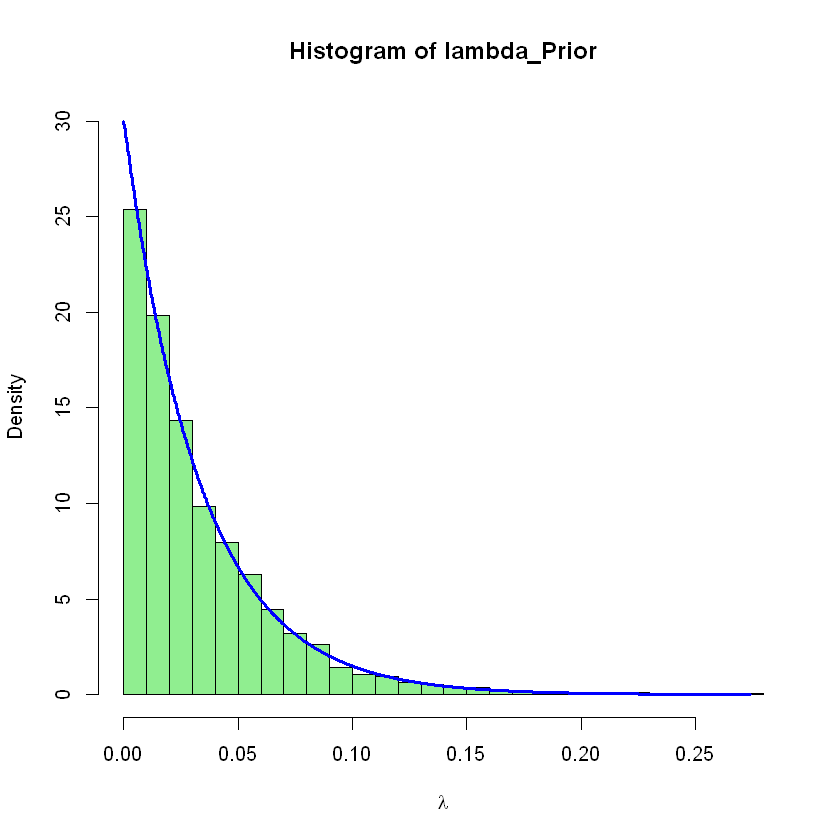

In [6]:
#Extract lambda:
lambda_Prior <- extract(stanFit_Prior, 'lambda')
lambda_Prior <- unlist(lambda_Prior, use.names=FALSE)

options(repr.plot.width=7,repr.plot.height=7)
#Histogram of the simulated distribution via Stan:
hist(lambda_Prior,freq=FALSE,col="LightGreen",xlab=expression(lambda),ylim=c(0,30),breaks=25)
v<-seq(0,max(lambda_Prior),length=1000)
#Line with the theorical distribution:
lines(v,dgamma(v,shape=a,rate=b),lwd=2.5,col="blue")

The histogram adjusts pretty good the theorical pdf. Let's do the same but now comparing the simulated predictive prior pdf:

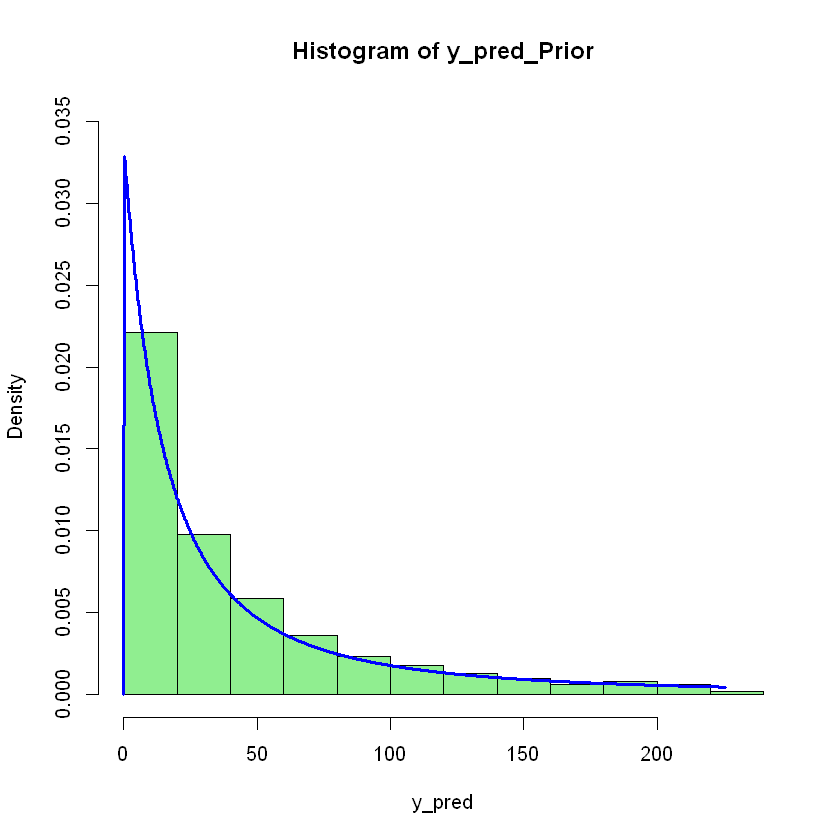

In [7]:
#Theorical Lomax pdf function:
Theor.pred.pdf<-function(y,a,b){return(ifelse(y>0,a*b^{a}/(y+b)^(a+1),0))}

#Extract y_pred:
y_pred_Prior <- extract(stanFit_Prior, 'y_pred')
y_pred_Prior <- unlist(y_pred_Prior, use.names=FALSE)

#Truncate it to the 90% quantile for visualization purposes:
y_pred_Prior <- y_pred_Prior[y_pred_Prior < quantile(y_pred_Prior, probs = 0.9)]

options(repr.plot.width=7,repr.plot.height=7)
#Histogram of the simulated prior via stan:
hist(y_pred_Prior,freq=FALSE,col="LightGreen", xlab = "y_pred", ylim = c(0,0.035))
v<-seq(0,max(y_pred_Prior),length=1000)
#Line with the theorical distribution:
lines(v,Theor.pred.pdf(v, a, b),lwd=2.5,col="blue")

#### Simulate posteriors

We define the same model string as before but without commenting the specification of the data in order to compute the posterior pdfs: 

In [8]:
modelString <- "
data {
    int<lower=0> n;
    real<lower=0> a; 
    real<lower=0> b;
    real<lower=0> y[n];
    }
parameters {
    real<lower=0.00001> lambda;
    }
model {
    lambda ~ gamma(a,b);
    y~exponential(lambda);
    }
generated quantities{                // Sampling from the lambda posterior
    real<lower=0> y_pred;
    y_pred = exponential_rng(lambda);
    }
    "

Recall that our data vector is $Y = (16, 8, 114, 60, 4, 23, 30, 105)$ and $n=8$. Let's set them:

In [9]:
y <- c(16, 8, 114, 60, 4, 23, 30, 105)
n <- length(y)

Now, we can compile the model and sample from the posterior pdf, with the same default parameters:

In [10]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model(model_code = modelString) 

#Initializate data with the defined above parameters:
dataList <- list(y = y, n = n, a = a, b = b)

# Generate simulated sample (default parameters):
set.seed(212312) #for reproductibillity reasons we set a fixed random seed
stanFit <- sampling(object = stanDso, data = dataList)
stanFit

Inference for Stan model: 4480d0ee243bf48fe4eb5378dfc9c442.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean    sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
lambda   0.02    0.00  0.01   0.01   0.02   0.02   0.03   0.04  1391    1
y_pred  48.05    0.93 55.55   1.02  12.66  31.09  61.86 202.28  3561    1
lp__   -43.42    0.02  0.72 -45.33 -43.55 -43.14 -42.97 -42.92  1243    1

Samples were drawn using NUTS(diag_e) at Tue Apr 26 20:53:12 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Let's compare now the simulated posterior pdf of $\lambda$ with the theorical one. We will calculate the theorical posterior a and b from the theory of conjugated pairs that says that  $\lambda\sim\operatorname{Gamma}(\alpha',\beta')$:

$$
    \left\{
    \begin{array}{lcl}
    \alpha'&=&\alpha+n,\\[0.2cm]
    \beta'&=&\beta+n\,\overline{y}.
    \end{array}\right.
$$

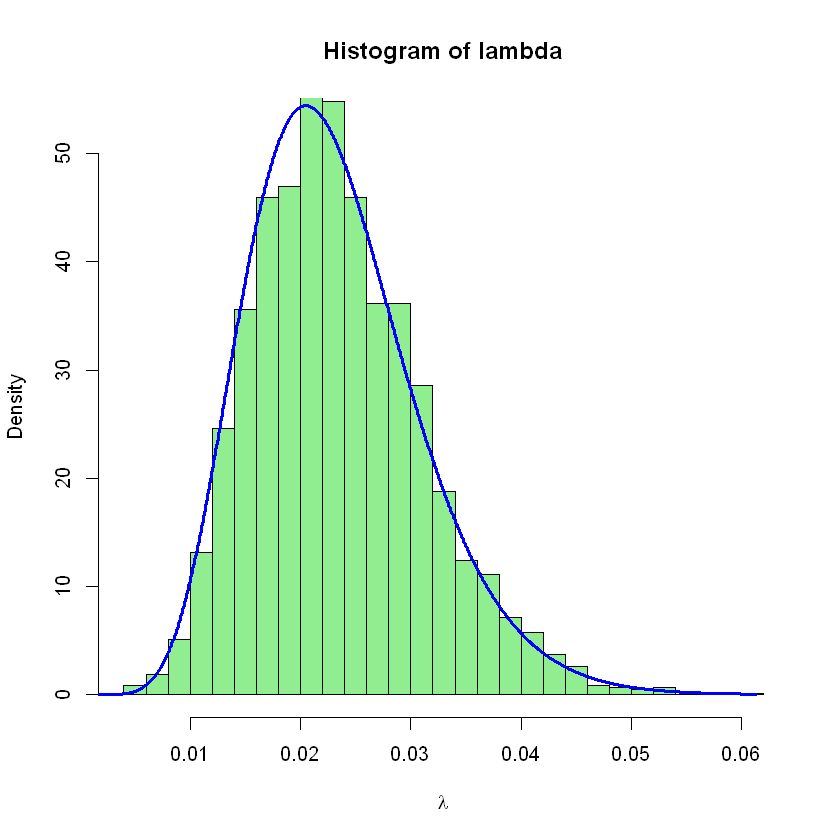

In [11]:
#Calculate theorical posterior a and b:
nybar <- sum(y)

post.a <- a + n
post.b <- b + nybar

#Extract lambda:
lambda <- extract(stanFit, 'lambda')
lambda <- unlist(lambda, use.names=FALSE)

options(repr.plot.width=7,repr.plot.height=7)
#Histogram of the simulated distribution via Stan:
hist(lambda,freq=FALSE,col="LightGreen",xlab=expression(lambda),breaks=25, ylim=c(0,53))
v<-seq(0,max(lambda),length=1000)
#Line with the theorical distribution:
lines(v,dgamma(v,shape=post.a,rate=post.b),lwd=2.5,col="blue")

Finally, we compare the simulated predictive posterior pdf with the theorical one.  We'll use also the posterior parameters a and b calculated before:

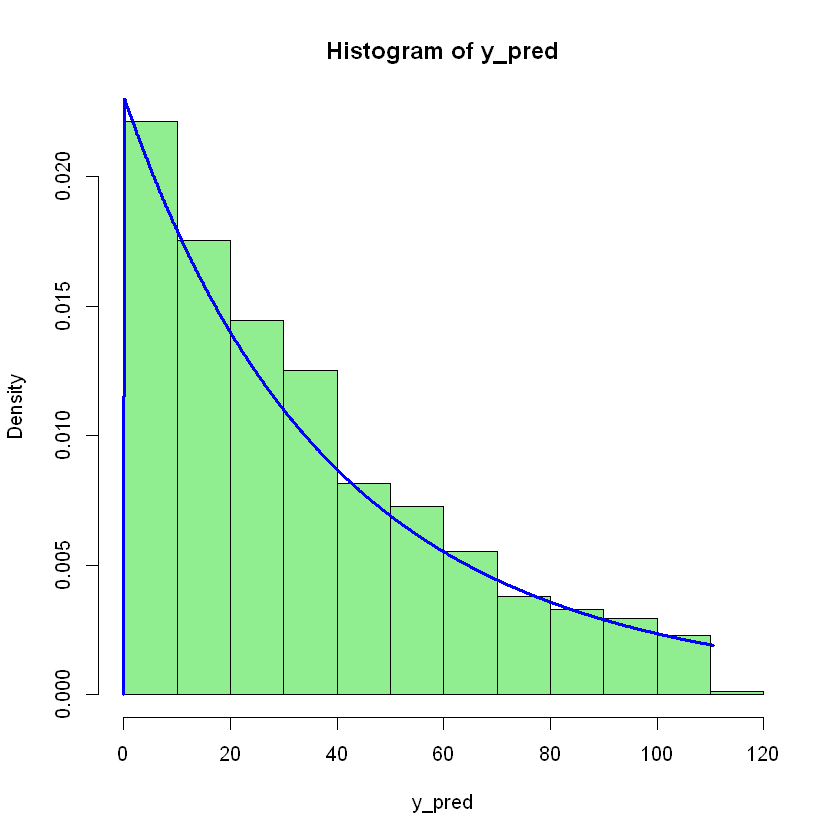

In [12]:
#Extract y_pred:
y_pred <- extract(stanFit, 'y_pred')
y_pred <- unlist(y_pred, use.names=FALSE)

#Truncate it to the 90% quantile for visualization purposes:
y_pred <- y_pred[y_pred < quantile(y_pred, probs = 0.9)]

options(repr.plot.width=7,repr.plot.height=7)
#Histogram of the simulated prior via stan:
hist(y_pred,freq=FALSE,col="LightGreen", xlab = "y_pred")
v<-seq(0,max(y_pred),length=1000)
#Line with the theorical distribution:
lines(v,Theor.pred.pdf(v, post.a, post.b),lwd=2.5,col="blue")

The adjusted posteriors function are very close to the theorical ones, so the adjustement with the default parameters is pretty good. Nevertheless, we define a function that given the parameters of the sampling function it plots all the histograms comparing prior and posterior pdfs to the teorical ones with the same code that we have done:

In [13]:
library(stringr) #for str_glue() function

#we put the same default parameters as the ones for the function:
compare_theorical <- function(iter = 2000, warmup = 1000, thin = 1, chains = 4){
    
    print(str_glue("Iterations: {iter} \n Warmup: {warmup} \n Thin: {thin} \n Chains: {chains}"))
    
    # Translate model to C++ and compile to DSO:
    stanDso <- stan_model(model_code = modelString_Prior) 

    #Initializate data with the defined above parameters:
    dataList <- list(n = n, a = a, b = b)

    # Generate simulated sample (default parameters):
    set.seed(212312)
    stanFit_Prior <- sampling(object = stanDso, data = dataList, iter = iter, warmup = warmup, thin = thin, chains = chains)
    
    #Extract lambda:
    lambda_Prior <- extract(stanFit_Prior, 'lambda')
    lambda_Prior <- unlist(lambda_Prior, use.names=FALSE)

    options(repr.plot.width=7,repr.plot.height=7)
    #Simulated distribution via Stan:
    hist(lambda_Prior,freq=FALSE,col="LightGreen",xlab=expression(lambda),ylim=c(0,30),breaks=25)
    v<-seq(0,max(lambda_Prior),length=1000)
    #Theorical distribution:
    lines(v,dgamma(v,shape=a,rate=b),lwd=2.5,col="blue")
    
    #Extract y_pred:
    y_pred_Prior <- extract(stanFit_Prior, 'y_pred')
    y_pred_Prior <- unlist(y_pred_Prior, use.names=FALSE)
    
    #Truncate it to the 90% quantile for visualization purposes:
    y_pred_Prior <- y_pred_Prior[y_pred_Prior < quantile(y_pred_Prior, probs = 0.9)]
    
    options(repr.plot.width=7,repr.plot.height=7)
    #Histogram of the simulated prior via stan:
    hist(y_pred_Prior,freq=FALSE,col="LightGreen", xlab = "y_pred", ylim = c(0,0.035))
    v<-seq(0,max(y_pred_Prior),length=1000)
    #Line with the theorical distribution:
    lines(v,Theor.pred.pdf(v, a, b),lwd=2.5,col="blue")
    
    #Posteriors:
    
    # Translate model to C++ and compile to DSO:
    stanDso <- stan_model(model_code = modelString) 

    #Initializate data with the defined above parameters:
    dataList <- list(y = y, n = n, a = a, b = b)

    # Generate simulated sample (default parameters):
    set.seed(212312)
    stanFit <- sampling(object = stanDso, data = dataList, chains = chains, iter = iter, warmup = warmup, thin = thin)
    #Extract lambda:
    lambda <- extract(stanFit, 'lambda')
    lambda <- unlist(lambda, use.names=FALSE)
    
    options(repr.plot.width=7,repr.plot.height=7)
    #Histogram of the simulated distribution via Stan:
    hist(lambda,freq=FALSE,col="LightGreen",xlab=expression(lambda),breaks=25, ylim=c(0,53))
    v<-seq(0,max(lambda),length=1000)
    #Line with the theorical distribution:
    lines(v,dgamma(v,shape=post.a,rate=post.b),lwd=2.5,col="blue")
    
    #Extract y_pred:
    y_pred <- extract(stanFit, 'y_pred')
    y_pred <- unlist(y_pred, use.names=FALSE)
    
    #Truncate it to the 90% quantile for visualization purposes:
    y_pred <- y_pred[y_pred < quantile(y_pred, probs = 0.9)]
    
    options(repr.plot.width=7,repr.plot.height=7)
    #Histogram of the simulated prior via stan:
    hist(y_pred,freq=FALSE,col="LightGreen", xlab = "y_pred")
    v<-seq(0,max(y_pred),length=1000)
    #Line with the theorical distribution:
    lines(v,Theor.pred.pdf(v, post.a, post.b),lwd=2.5,col="blue")
    
}

We can increase the chains and the iterations, taking in account that high numbers might kill the kernel. Let's see for example the results with chains up to 100 and 4000 iterations:

Iterations: 4000 
Warmup: 1000 
Thin: 1 
Chains: 100


Warning message:
"There were 26 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


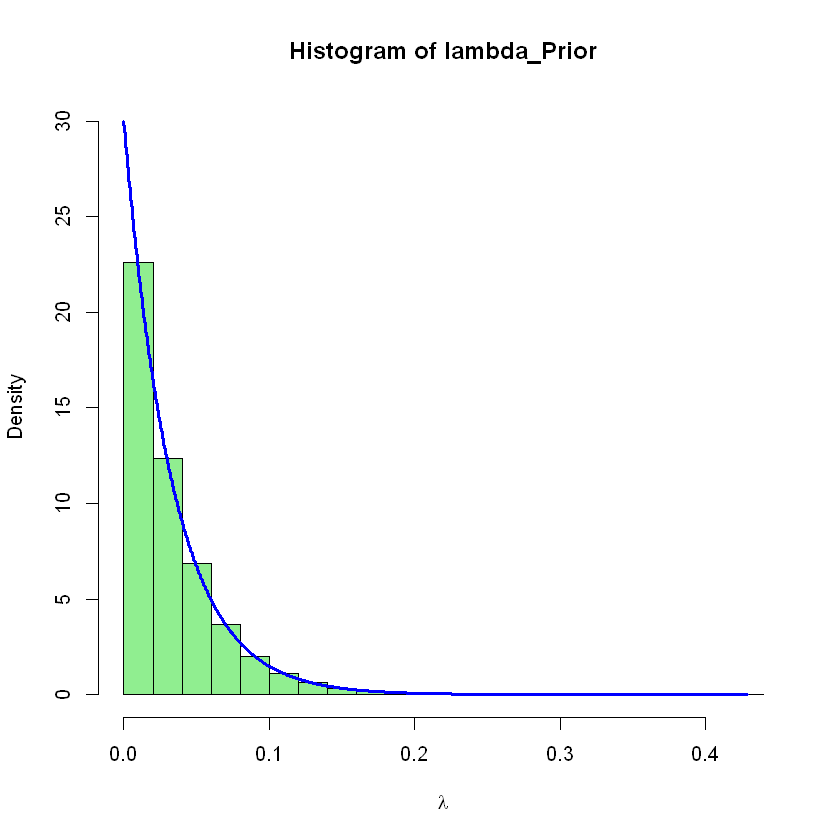

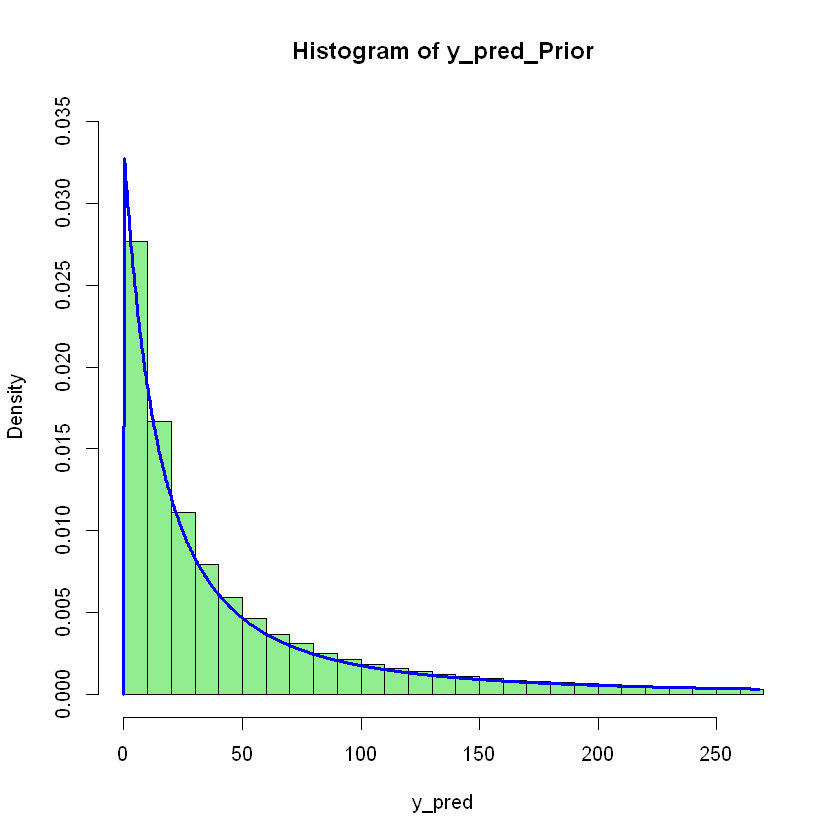

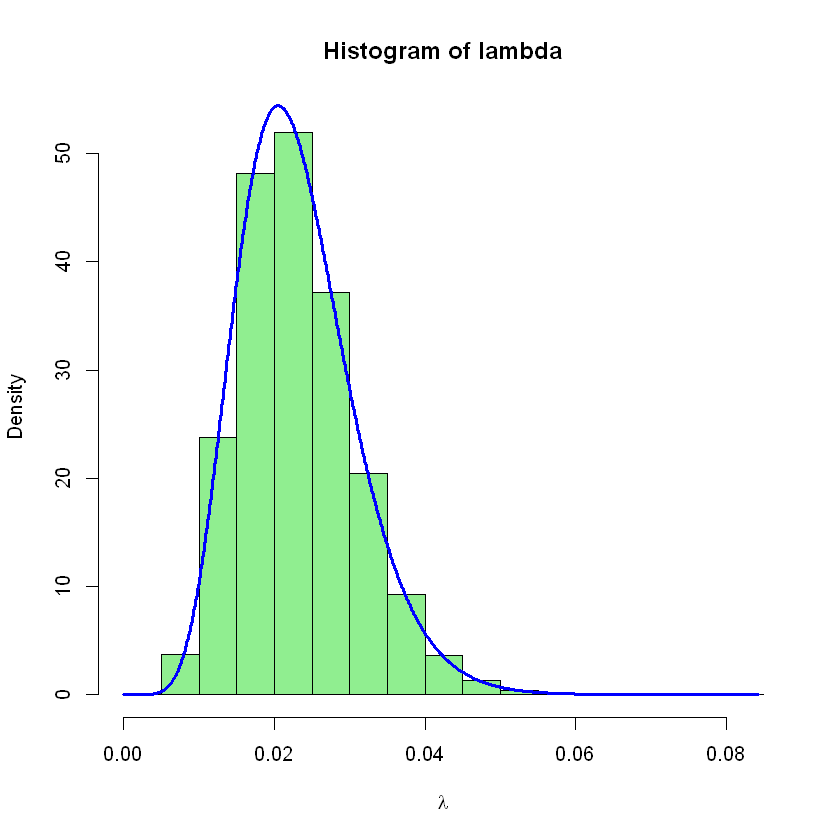

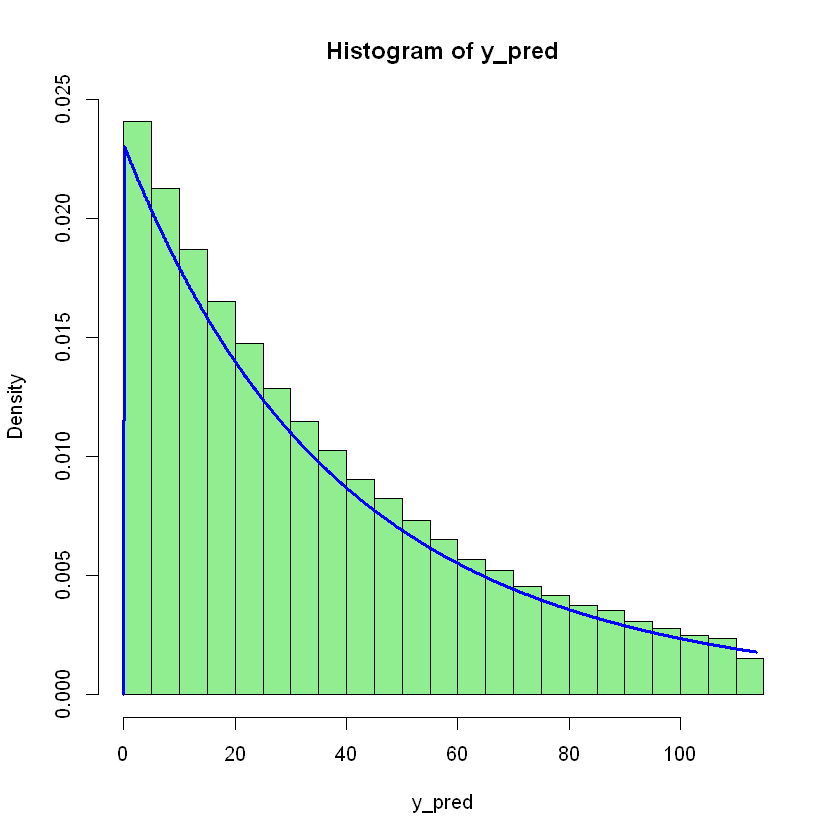

In [14]:
compare_theorical(iter = 4000, chains = 100)

We see that the results improve a little, having a best approximation of y_pred both in prior and posterior pdfs.

<h1 style="color:blue">02 - A more elaborate mixture prior for the spinning coin</h1>

(continued from Diaconis experiment)

On reflection, it was decided that tails had come up more often than heads in the past; further some coins seemed likely to be symmetric. 

Thus, a final approximation to the prior was taken as:

$$
    0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

Same observed data as in the previous model.

In [15]:
# Number of trials
n<-10
# Observed x
x.obs<-3

Perform a complete Bayesian analysis of this model, in close parallel to the first example.

(1) Using the theoretical formulas (prior predictive pmf, posterior pdf, posterior predictive pmf)

(2) Using independent random numbers (`rbeta()` functions, etc.)

(3) JAGS version

(4)$ {}^{\star}$ Stan version. 

>$ (\star)$ Hint: this one **is difficult** due to intrinsic limitations in Stan. There are several known workarounds; you can try to find one but do not despair if you fail to develop a workable version.

>As a matter of fact even a Stan version of the two-components prior mixture in `Mixture.priors.02.ipynb` 
is rather tricky: Stan does not allow integer parameters thus the JAGS code cannot be translated literally.

Diaconis and Ylvisaker (1985) compare both mixture conjugate priors with a $ \operatorname{Unif}(0,1)$ prior with the data above. 

Comparing the MAP estimators, they observe that in a first approximation, they coincide, but spreads do depend on the prior.

They repeat the computations above with a larger sample. 

In [16]:
n1<-50
x1.obs<-14

Their conclusion is that with small data, prior matters, but with larger samples, a finely tuned choice of prior is less important.

### Resolution

In [17]:
require(MASS) # for truehist
#install.packages("extraDistr", dependencies=TRUE, repos= "https://cloud.r-project.org")
require(extraDistr) # needed for the Beta-binomial predictive prior

Loading required package: MASS

Loading required package: extraDistr

Warning message:
"package 'extraDistr' was built under R version 4.1.2"


### 2.1 Using theorical formulas

##### Prior $\theta$ pdf 

As stated above, the parameter $\theta$ follows a prior distribution $\theta \sim 0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$ Let's initialize the prior parameters given this approximation:

In [18]:
prior.a1 <- 10
prior.b1 <- 20
prior.a2 <- 15
prior.b2 <- 15
prior.a3 <- 20
prior.b3 <- 10
prior.gamma1 <- 0.5
prior.gamma2 <- 0.2
prior.gamma3 <- 1 - (prior.gamma1 + prior.gamma2)

So, the prior parameter follows a mixture of three beta distributions that we can represent:

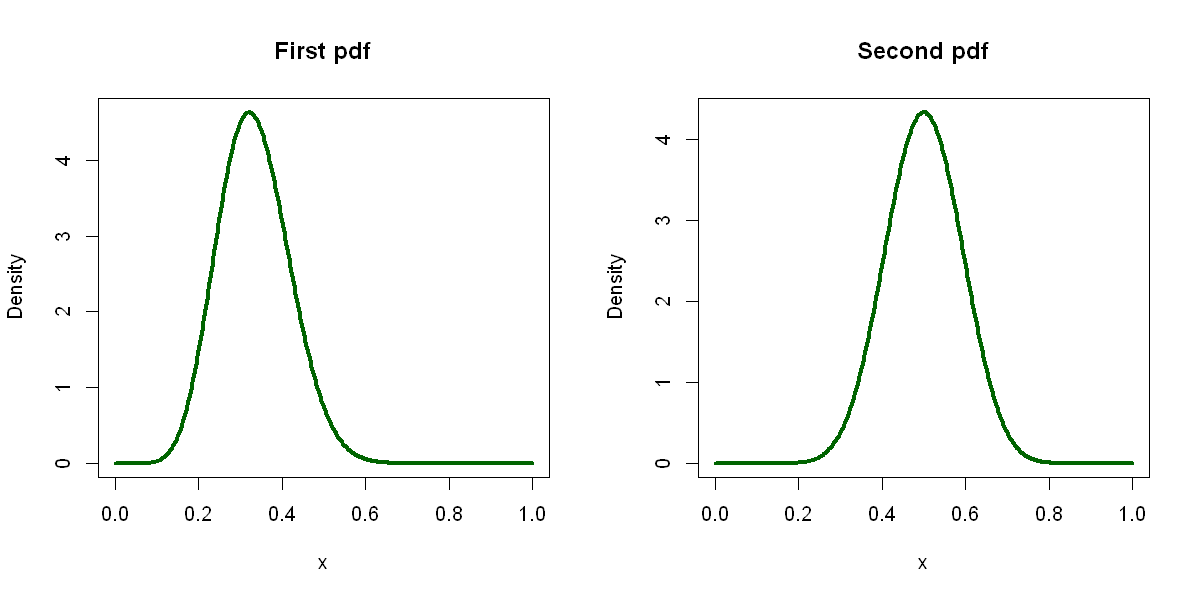

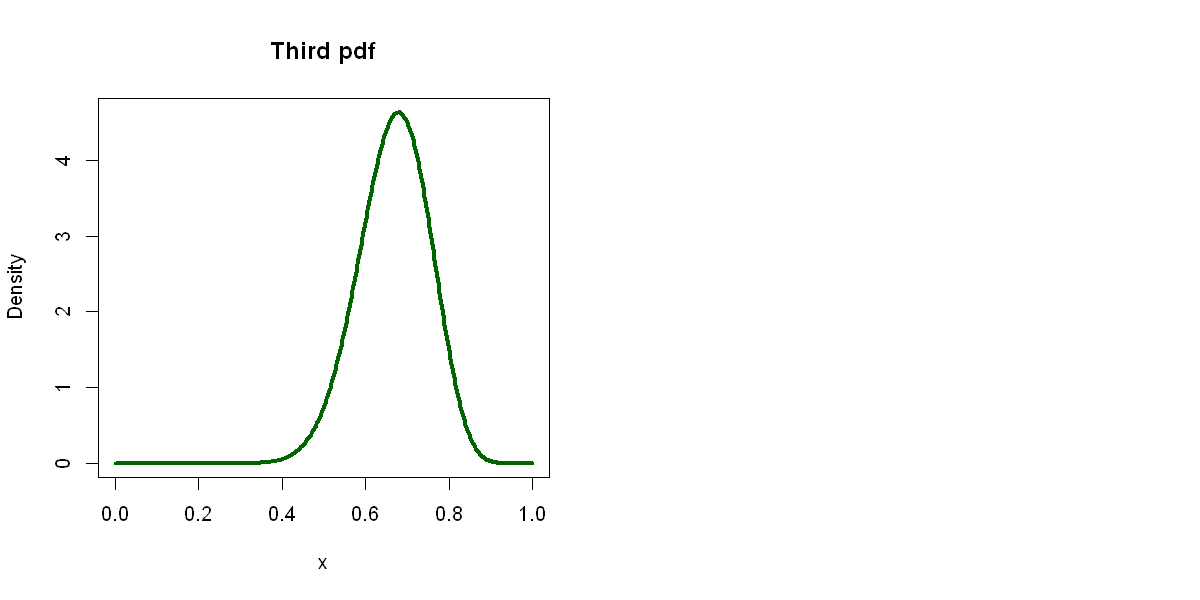

In [19]:
options(repr.plot.width=10,repr.plot.height=5)
v<-seq(0,1,length=500)
old.par<-par(mfrow=c(1,2))
plot(v,dbeta(v,prior.a1,prior.b1),type="l",lwd=3.5,col="DarkGreen",xlab="x",ylab="Density",main="First pdf")
plot(v,dbeta(v,prior.a2,prior.b2),type="l",lwd=3.5,col="DarkGreen",xlab="x",ylab="Density",main="Second pdf")
plot(v,dbeta(v,prior.a3,prior.b3),type="l",lwd=3.5,col="DarkGreen",xlab="x",ylab="Density",main="Third pdf")
par(old.par)

Let's define the prior pdf function for $\theta$ based on the parameters and the expression defined above and let's plot it:

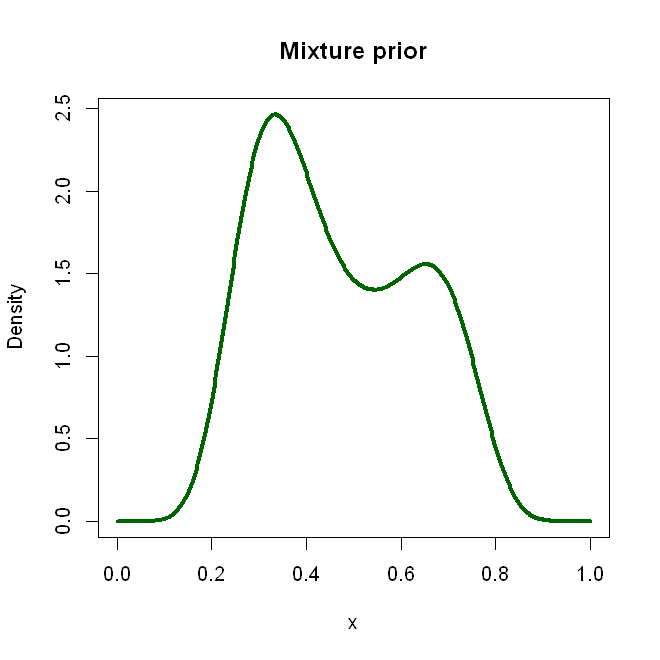

In [20]:
#x will be a vector of possible values that can take the beta distribution (thus between 0 and 1)
mixture.prior.pdf<-function(x){
    return(prior.gamma1*dbeta(x,prior.a1,prior.b1)+prior.gamma2*dbeta(x,prior.a2,prior.b2)+prior.gamma3*dbeta(x,prior.a3,prior.b3))
    }

options(repr.plot.width=5.5,repr.plot.height=5.5)
v<-seq(0,1,length=500)
plot(v,mixture.prior.pdf(v),type="l",lwd=3.5,col="DarkGreen",xlab="x",ylab="Density",main="Mixture prior")

##### Prior predictive pmf

As stated in the notebook's example the likelihood follows $\sim \binomdist(n,\theta)$ so it can be deduced that the joint pdf would be 

$$
	f(x,\theta)=\gamma_1\cdot f_{1}(x,\theta)+\gamma_2\cdot  f_{2}(x,\theta)+\gamma_3\cdot f_3(x,\theta).
$$ 

where

$$
\begin{align*}
	f_{1}\sim\operatorname{Beta-Binom}(n,\alpha_{1},\beta_{1})&=\operatorname{Beta-Binom}(10,10,20),\\
	f_{2}\sim\operatorname{Beta-Binom}(n,\alpha_{2},\beta_{2})&=\operatorname{Beta-Binom}(10,15,15),\\
    f_{3}\sim\operatorname{Beta-Binom}(n,\alpha_{3},\beta_{3})&=\operatorname{Beta-Binom}(10,20,10)
\end{align*}
$$

and $\gamma_1=0.5$, $\gamma_2=0.2$, $\gamma_3=0.3$ for the prior and being $n = 10$ the number of trials of this example.

Let's define the functions defined above and the predictive prior pdf and plot it. Because Beta-Binom only can take integer values from 0 to n we will plot the pmf and not the pdf:

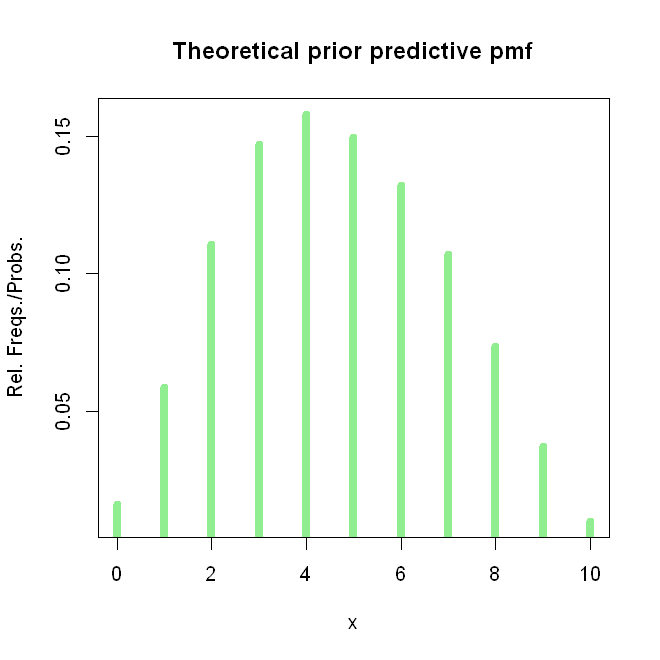

In [21]:
f1<-function(x){dbbinom(x,size=n,alpha=prior.a1,beta=prior.b1)}
f2<-function(x){dbbinom(x,size=n,alpha=prior.a2,beta=prior.b2)}
f3<-function(x){dbbinom(x,size=n,alpha=prior.a3,beta=prior.b3)}

n <- 10 #number of trials 

#x will be the support of the beta-binom pdf (between 0 and n):
Theor.prior.predictive.pmf<-function(x){
    return(prior.gamma1*f1(x)+prior.gamma2*f2(x)+prior.gamma3*f3(x))
}

options(repr.plot.width=5.5,repr.plot.height=5.5)
v<-0:n
matplot(x=v,y=Theor.prior.predictive.pmf(v),type="h",lwd=7, lty=1,col=c("LightGreen","DarkGreen"),xlab="x",ylab="Rel. Freqs./Probs.",
        main="Theoretical prior predictive pmf")

##### Posterior $\theta$ pdf

From the conjugated property of the $\theta$ prior distribution we know that the posterior distribution of $\theta$ will belong to the same family but with updated posterior parameters, so: 

$$ 
	h(\theta\,|\,x)=\widehat{\gamma}_1(x)\cdot h_{1}(\theta\,|\,x)
		+\widehat{\gamma}_2(x)\cdot h_{2}(\theta\,|\,x) +\widehat{\gamma}_3(x)\cdot h_{3}(\theta\,|\,x),
$$

From Bayes' formula we can express the posterior $\theta$ pdf as a function of the prior joint pdf and the marginal pdf of the observed data:

$$
    h(\theta\,|\,x)=\dfrac{f(x,\theta)}{f(x)}
        =\dfrac{\gamma_1\cdot f_{1}(x,\theta)+\gamma_2\cdot  f_{2}(x,\theta) + \gamma_3\cdot  f_{3}(x,\theta)}
            {\gamma_1\cdot f_{1}(x)+\gamma_2\cdot f_{2}(x)+\gamma_3\cdot f_{3}(x)}.
$$

Then, taking the first formula we can replace $h_i(x)$ by the following Bayes' expression:

$$h_{i}(\theta\,|\,x)=\dfrac{f_{i}(x,\theta)}{f_{i}(x)}	\quad i=1,2, 3$$

So combining the two first formulas and equaling each sumand we can deduce:

$$
	\widehat{\gamma}_i(x)=\dfrac{\gamma_i\cdot f_{i}(x)}{\gamma_1\cdot f_{1}(x)+\gamma_2\cdot f_{2}(x)+\gamma_3\cdot f_{3}(x)} \quad i=1,2,3.
$$


Let's calculate them using $f_i(x)$ we have defined above and the observed data x=3:

In [22]:
# Observed x
x.obs<-3

posterior.gamma1<-prior.gamma1*f1(x.obs)/(prior.gamma1*f1(x.obs)+prior.gamma2*f2(x.obs)+prior.gamma3*f3(x.obs))
posterior.gamma2<-prior.gamma2*f2(x.obs)/(prior.gamma1*f1(x.obs)+prior.gamma2*f2(x.obs)+prior.gamma3*f3(x.obs))
posterior.gamma3<-prior.gamma3*f3(x.obs)/(prior.gamma1*f1(x.obs)+prior.gamma2*f2(x.obs)+prior.gamma3*f3(x.obs))

#If we have done it correctly the sum of all of them would have to be 1:
print(posterior.gamma1 + posterior.gamma2 + posterior.gamma3)

[1] 1


Now let's compute the partial posterior $\theta$ pdf's from the conjugate pair formulas:

$$
\begin{array}{l}
	h_{1}\sim\operatorname{Beta}(\alpha_{1}+x,\beta_{1}+n-x)=\operatorname{Beta}(10+3,20+10-3)
        =\operatorname{Beta}(13,27),\\
	h_{2}\sim\operatorname{Beta}(\alpha_{2}+x,\beta_{2}+n-x)=\operatorname{Beta}(15+3,15+10-3)
        =\operatorname{Beta}(18,22),\\
    h_{3}\sim\operatorname{Beta}(\alpha_{3}+x,\beta_{3}+n-x)=\operatorname{Beta}(20+3,10+10-3)
        =\operatorname{Beta}(23,17).    
\end{array}
$$

In [23]:
posterior.a1 <- prior.a1 + x.obs
posterior.b1 <- prior.b1 + n - x.obs
posterior.a2 <- prior.a2 + x.obs
posterior.b2 <- prior.b2 + n - x.obs
posterior.a3 <- prior.a3 + x.obs
posterior.b3 <- prior.b3 + n - x.obs

Now we can plot the $\theta$ posterior pdf:

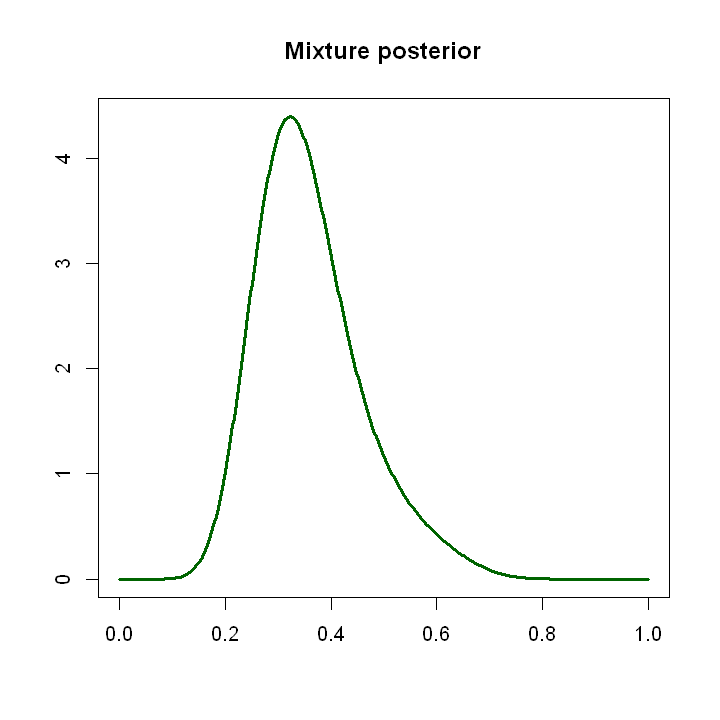

In [24]:
mixture.posterior.pdf<-function(x){
    return(posterior.gamma1*dbeta(x,posterior.a1,posterior.b1)+posterior.gamma2*dbeta(x,posterior.a2,posterior.b2)+posterior.gamma3*dbeta(x,posterior.a3,posterior.b3))
}

# Plot the posterior pdf
options(repr.plot.width=6,repr.plot.height=6)
v<-seq(0,1,length=500)
plot(v,mixture.posterior.pdf(v),"l",lwd=2.5,col="DarkGreen",xlab="",ylab="",main="Mixture posterior")

##### Posterior predictive pmf

We know the expression of the predictive pmf so we have only to calculate it with the updated parameters:

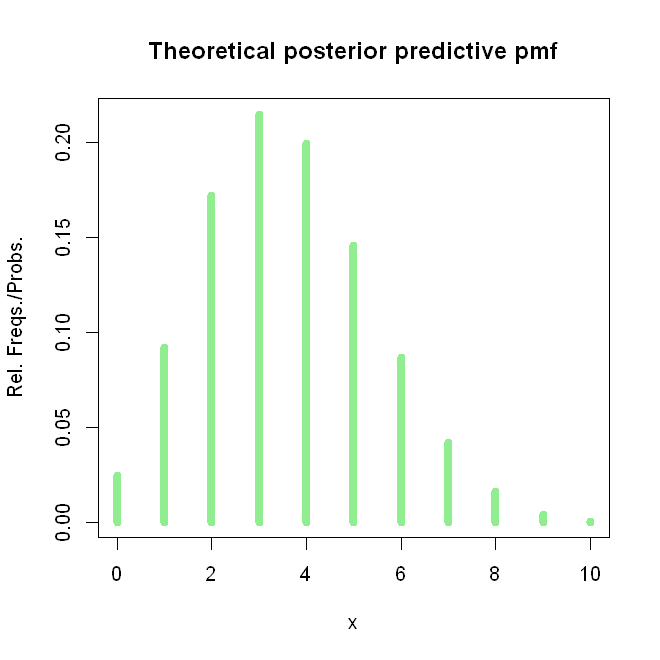

In [25]:
posterior.f1<-function(x){dbbinom(x,size=n,alpha=posterior.a1,beta=posterior.b1)}
posterior.f2<-function(x){dbbinom(x,size=n,alpha=posterior.a2,beta=posterior.b2)}
posterior.f3<-function(x){dbbinom(x,size=n,alpha=posterior.a3,beta=posterior.b3)}

#x will be again the support of the beta-binom pdf (between 0 and n):
Theor.posterior.predictive.pmf<-function(x){
    return(posterior.gamma1*posterior.f1(x)+posterior.gamma2*posterior.f2(x)+posterior.gamma3*posterior.f3(x))
}

options(repr.plot.width=5.5,repr.plot.height=5.5)
v<-0:n
matplot(x=v,y=Theor.posterior.predictive.pmf(v),type="h",lwd=7, lty=1,col="LightGreen",xlab="x",ylab="Rel. Freqs./Probs.",
        main="Theoretical posterior predictive pmf")

Podem comparar-ho amb la prior per veure com ha canviat la informació i afegir l'anàlisis de les posteriors quantities!!

### 2.2. Using independent random numbers

#### $\theta$ prior

Let's generate 20000 samples of the $\theta$ following the prior distribution defined above, mixture of the three different beta distributions and binomial weights with prior probabilities of 0.5, 0.2 and 0.3.

For that we have to assign a probability to each distribution, in order to know to which of the three distributions it will be the theta sampled from. As we know:

$$
   0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

So we will give the first, second and third distribution a probability of 0.5,0.2 and 0.3, respectively:

In [26]:
N <- 20000 #Number of simulated samples

set.seed(1231) #Random seed number

# Defining the probabilities of the three distributions
beta_dist <- sample(c(1,2,3), replace = TRUE, size = N, prob=c(0.5, 0.2, 0.3))

# pick coins from the distributions (with replacement) in order to generate thetas
Sim.prior.theta <- ifelse(beta_dist == 1, rbeta(N, 10, 20), ifelse(beta_dist == 2, rbeta(N, 15, 15), rbeta(N, 20, 10)))

Let's plot the generated simulated distribution:

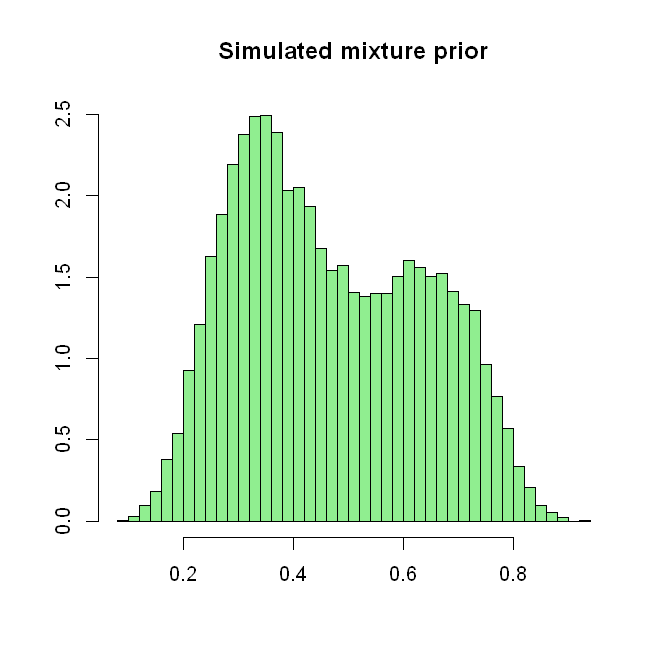

In [27]:
options(repr.plot.width=5.5,repr.plot.height=5.5)
truehist(Sim.prior.theta,ylim=c(0,2.5),nbins=30,col="LightGreen",xlab="",ylab="",main="Simulated mixture prior")

#### Predictive prior

From the generated $\theta$ samples before, simulate samples from the predictive prior distribution knowing that it follows a binomial distribution of parameter $\theta$:

In [28]:
#Generate samples of the predictive:
Sim.x.prior.pred <- rbinom(N, size=n, prob=Sim.prior.theta)

Calculate the obtained simulated frequencies and plot them in a histogram:

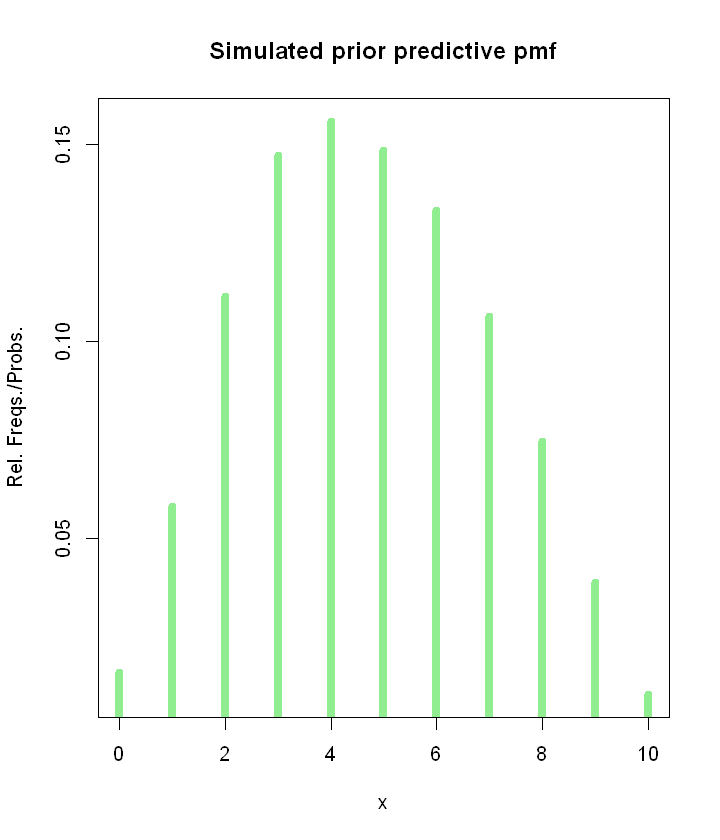

In [29]:
T.Sim.x.prior.pred <- table(Sim.x.prior.pred)
f.Sim.x.prior.pred <- T.Sim.x.prior.pred/N
options(repr.plot.width=6,repr.plot.height=7)
v <- names(T.Sim.x.prior.pred)
matplot(x=v,y=f.Sim.x.prior.pred,type="h",lwd=7, lty=1,col="LightGreen",xlab="x",ylab="Rel. Freqs./Probs.",
        main="Simulated prior predictive pmf")

#### Posterior $\theta$

To calculate the posterior probability of having m=3 heads given prior $\theta$, we pick all cases resulting in m=3 heads and update the posterior. Calculate the posterior $\theta$ given that the observed x is 3:

In [30]:
x.obs.indexes <- (Sim.x.prior.pred==x.obs)
N.post <- sum(x.obs.indexes)     # Posterior sample size
Prop.N.post <- N.post/N  

print(str_glue("{N.post} ({round(Prop.N.post*100,2)}%) of times the simulated prior predicted is the true one"))

Sim.post.theta <- Sim.prior.theta[x.obs.indexes]

2946 (14.73%) of times the simulated prior predicted is the true one


Plot the posterior $\theta$ distribution:

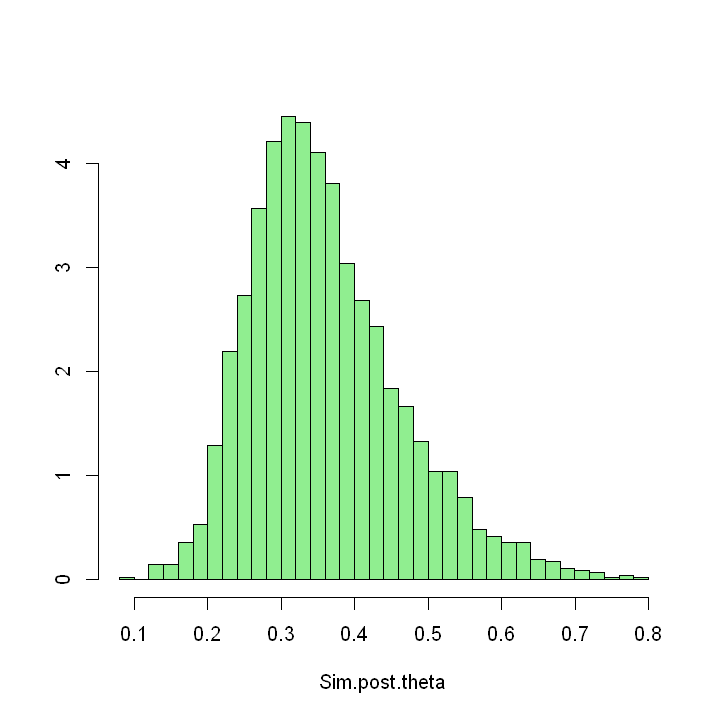

In [31]:
options(repr.plot.width=6, repr.plot.height=6)
truehist(Sim.post.theta, col="LightGreen")

#### Posterior predicitve pmf

From the samples of the simulated posterior $\theta$ let's calculate the posterior predictive pmf:

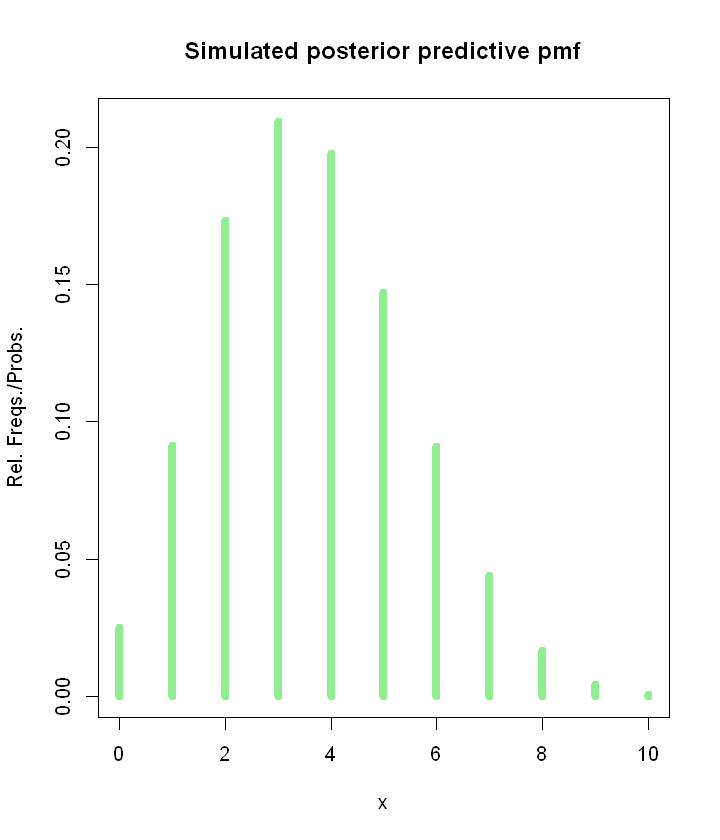

In [32]:
#Generate samples of the predictive:
Sim.x.post.pred <- rbinom(N, size=n, prob=Sim.post.theta)

#Calculate as before counts and frequencies of the simulated distribution:
T.Sim.x.post.pred <- table(Sim.x.post.pred)
f.Sim.x.post.pred <- T.Sim.x.post.pred/N
options(repr.plot.width=6,repr.plot.height=7)
v <- names(T.Sim.x.prior.pred)
matplot(x=v,y=f.Sim.x.post.pred,type="h",lwd=7, lty=1,col="LightGreen",xlab="x",ylab="Rel. Freqs./Probs.",
        main="Simulated posterior predictive pmf")

#### Analysis of posterior quantities

Now we show the expected value, variance and sd of the posterior $\theta$ distribution:

In [33]:
expected.post.theta<-mean(Sim.post.theta)
var.post.theta<-var(Sim.post.theta)
sd.post.theta<-sd(Sim.post.theta)

print(paste0("The expected value is: ", round(expected.post.theta,3)))
print(paste0("The variance is: ", round(var.post.theta,3)))
print(paste0("The sd value is: ", round(sd.post.theta,3)))

[1] "The expected value is: 0.361"
[1] "The variance is: 0.011"
[1] "The sd value is: 0.103"


Finally find the maximum a posteriori

In [34]:
MAP <- density(Sim.post.theta)$x[which.max(density(Sim.post.theta)$y)]
print(paste0("The maximum a posteriori is: ", round(MAP,3)))

[1] "The maximum a posteriori is: 0.315"


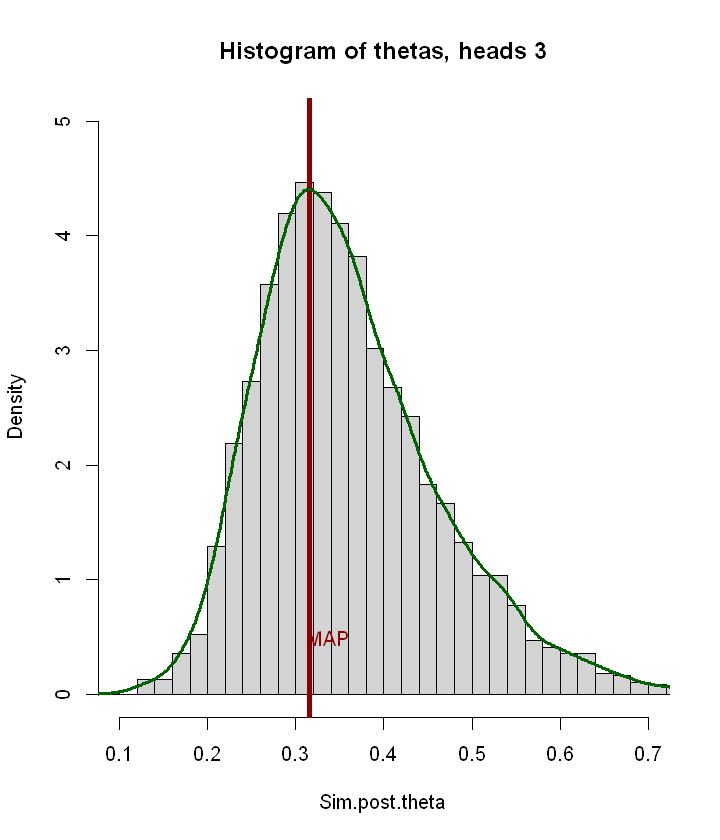

In [35]:
# Plot over histogram
hist(Sim.post.theta, breaks=50, freq=FALSE,xlim = c(0.1,0.7), ylim = c(0,5), main="Histogram of thetas, heads 3")
abline(v=MAP,col="DarkRed",lwd=4)

lines(density(Sim.post.theta)$x,density(Sim.post.theta)$y,lwd=2.5,col="DarkGreen")
text(0.337, 0.5, "MAP", col="DarkRed")

#### Credible interval

### 2.3 JAGS

For installing the package we have to install also the dependencies it has. 'rjags' package can't be installed automatically from CRAN because it gives an error, we have to manually install the zip file from the cran repository (commented code):

In [36]:
#Link to find the zip file: https://cran.r-project.org/web/packages/rjags/index.html
# install.packages('C:/Users/psatorra/Downloads/rjags_4-13.zip', repos = NULL, type = "win.binary")
# install.packages("R2jags",dependencies=TRUE,repos= "https://cloud.r-project.org")
#Load library
require(R2jags)

Loading required package: R2jags

Warning message:
"package 'R2jags' was built under R version 4.1.3"
Loading required package: rjags

Warning message:
"package 'rjags' was built under R version 4.1.3"
Loading required package: coda


Attaching package: 'coda'


The following object is masked from 'package:rstan':

    traceplot


Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: 'R2jags'


The following object is masked from 'package:coda':

    traceplot


The following object is masked from 'package:rstan':

    traceplot




With JAGS we will only compute the distribution of the posterior parameters:

Declare the parameters defined above that will be used by the model:

In [37]:
Mix.01.dat<-list(a1=prior.a1,b1=prior.b1,
                 a2=prior.a2,b2=prior.b2,
                 a3=prior.a3,b3=prior.b3,
                 gamma1=prior.gamma1,gamma2=prior.gamma2,
                 n=n,x=x.obs)

Specify the model and save it in a jag file. We have adapted the base notebook code to our example with three distributions instead of two. We have to add also a line in order to estimate the predictive posterior:

In [38]:
cat(
"model
    {
    x~dbin(p,n)             # Binomial likelihood
    
    p<-theta[r]             # Prior is a mixture of two beta r.v 
                            # Notice the syntax: this statement says that p is
                            # *equal to* the pair of theta variates defined below

    r~dcat(g[])             # Categorical distribution:
                            # g[] is a 3-vector containing the mixing probabilities (gamma1, gamma2, gamma3)

    theta[1]~dbeta(a1,b1)   # The three beta r.v to enter the mixture
    theta[2]~dbeta(a2,b2)
    theta[3]~dbeta(a3,b3)

    g[1]<-gamma1             # Just as in p. g is equal to (gamma1, gamma2, gamma3)
    g[2]<-gamma2
    g[3]<-1-(gamma1+gamma2)

    x_PostPred~dbin(p, n) #Posterior predictive

    }"
    ,file="Mix.01.jag")

Let's run it:

In [39]:
Mix.01.m1<-jags(data=Mix.01.dat, n.chains=3,n.iter=5000,n.burnin=500, 
        parameters.to.save=c("theta","p", "x_PostPred"), model.file="Mix.01.jag")

module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 5
   Total graph size: 20

Initializing model



In [40]:
print(Mix.01.m1)

Inference for Bugs model at "Mix.01.jag", fit using jags,
 3 chains, each with 5000 iterations (first 500 discarded), n.thin = 4
 n.sims = 3375 iterations saved
           mu.vect sd.vect  2.5%   25%   50%   75% 97.5%  Rhat n.eff
p            0.363   0.102 0.200 0.290 0.349 0.422 0.601 1.001  2400
theta[1]     0.329   0.077 0.191 0.274 0.328 0.381 0.489 1.002  1600
theta[2]     0.491   0.090 0.320 0.427 0.490 0.552 0.666 1.001  3400
theta[3]     0.664   0.088 0.487 0.606 0.668 0.725 0.823 1.001  2500
x_PostPred   3.646   1.809 1.000 2.000 4.000 5.000 8.000 1.001  3400
deviance     3.259   1.033 2.643 2.693 2.858 3.327 6.353 1.001  3400

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 0.5 and DIC = 3.8
DIC is an estimate of expected predictive error (lower deviance is better).


#### Posterior $\theta$ distribution

As we have saved $\theta$ parameter, we can access to the values sampled directly and plot its distribution:

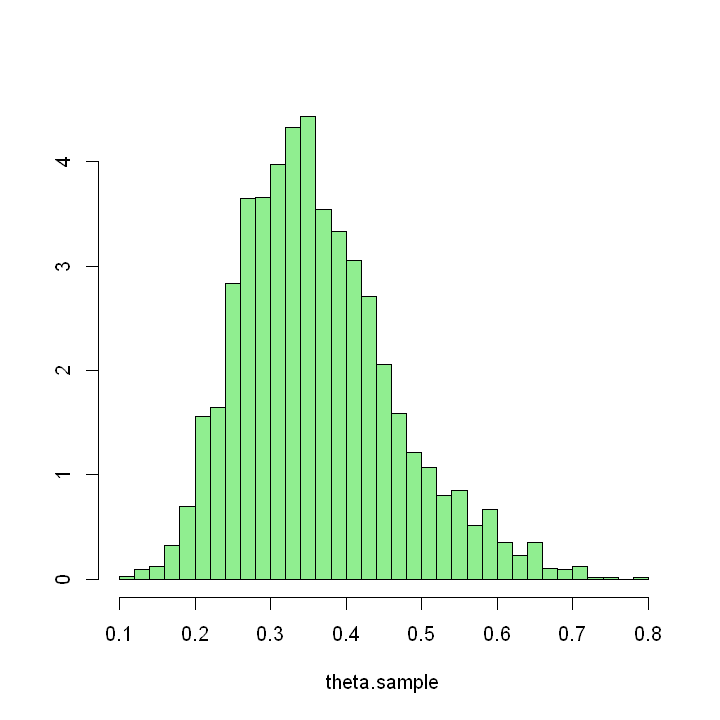

In [41]:
options(repr.plot.width=12,repr.plot.height=6)
theta.sample <- Mix.01.m1$BUGSoutput$sims.list$p

options(repr.plot.width=6, repr.plot.height=6)
truehist(theta.sample, col="LightGreen")

#### Posterior predictive distribution

We can also access to the posterior predictive sample directly and plot it's distribution:

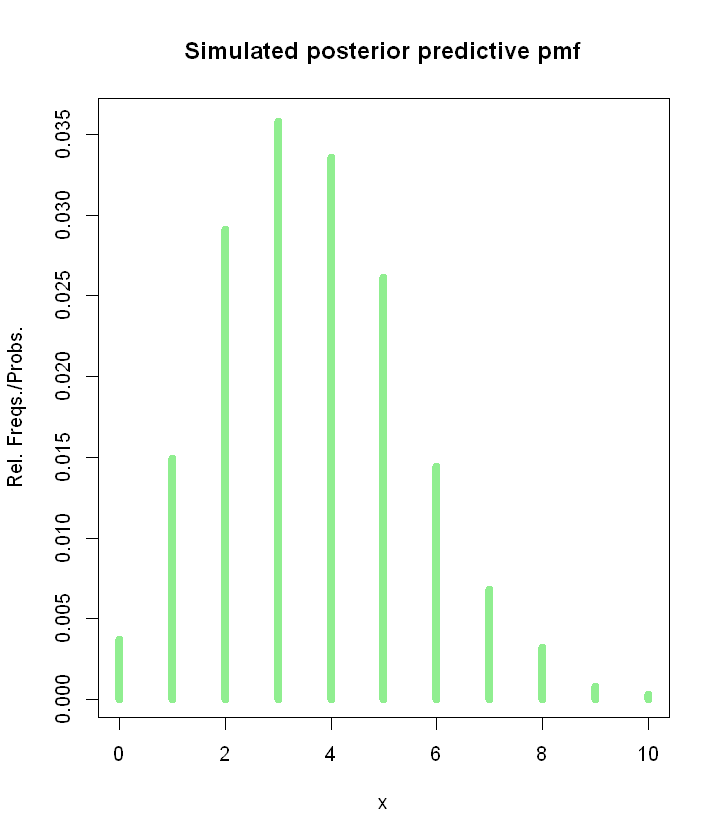

In [42]:
options(repr.plot.width=12,repr.plot.height=6)
x_PostPred.sample <- Mix.01.m1$BUGSoutput$sims.list$x_PostPred
#Calculate as before counts and frequencies of the simulated distribution:
T.x_PostPred.sample <- table(x_PostPred.sample)
f.x_PostPred.sample <- T.x_PostPred.sample/N
options(repr.plot.width=6,repr.plot.height=7)
v <- names(T.x_PostPred.sample)
matplot(x=v,y=f.x_PostPred.sample,type="h",lwd=7, lty=1,col="LightGreen",xlab="x",ylab="Rel. Freqs./Probs.",
        main="Simulated posterior predictive pmf")

### 2.4 Stan

As in JAGS we will only calculate the posterior samples of $\theta$ and the predicted distribution.

Stan is unable to simulate discrete parameters as we have in our example. So, a workaround is to simulate a random uniform $u\sim\unifdist(0,1)$. Then, given $\gamma_1$, $\gamma_2$, $\gamma_3$ the weights of the mixture, we will divide the interval $(0,1)$ on three parts the length of each given by the value of each $\gamma_i$ so the part of the interval where $u$ falls will be the distribution selected for $\theta$. In this way, the probability that a distribution is chosen is equal to the weights of the gamma parameters, because $u$ is uniform.

To implement it in Stan we have to evaluate the part of the interval where $u$ falls using two concatenated max functions and logic operators. Basically, we evaluate if it falls in the $i$-th interval giving a $i$ (if true) or a 0 (if false) and then we do the maximum that will give the $i$-th number where it falls.

In [43]:
modelString = "
    data{
        int<lower=0> n ;
        int<lower=0> x ; 
        real<lower=0> a1 ;
        real<lower=0> b1 ;
        real<lower=0> a2 ;
        real<lower=0> b2 ;
        real<lower=0> a3 ;
        real<lower=0> b3 ;
        real<lower=0,upper=1>  gamma1 ;
        real<lower=0,upper=1-gamma1>  gamma2 ;
        }
    parameters{
        real<lower=0,upper=1>  u ;
        vector<lower=0,upper=1>[3] theta ;
        }
    transformed parameters{                         
        real<lower=0,upper=1> p ;                   
                                                    // Here the trick:
                                                    // Generate on the spot the unnamed index selecting 
                                                    // which of both components in the mixture is chosen

        p=theta[max(max(u<gamma1?1:0, u<(gamma1+gamma2) && u>gamma1?2:0), u>(gamma1+gamma2)?3:0)] ;
        }
    model{
        x ~ binomial(n,p) ;
        theta[1]~beta(a1,b1) ;
        theta[2]~beta(a2,b2) ;
        theta[3]~beta(a3,b3) ;
        u ~ uniform(0,1) ; 
        }
    generated quantities{                           // Sampling from the posterior theta
        int<lower=0, upper=10> x_pred ;
        x_pred = binomial_rng(n, p) ;
}
"

Let's compile and run the model with our data:

In [44]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model( model_code=modelString ) 
Mix.01.Standat<-list(a1=prior.a1,b1=prior.b1,a2=prior.a2,b2=prior.b2,a3=prior.a3,b3=prior.b3,gamma1=prior.gamma1, gamma2=prior.gamma2,n=n,x=x.obs)
# Generate posterior sample:
stanFit <- sampling( object=stanDso, 
                     data = Mix.01.Standat, 
                     chains = 3,
                     iter = 4000, 
                     warmup = 200, 
                     thin = 1)

Warning message:
"There were 3511 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"


Let's see a quick overview of the results obtained:

In [45]:
S<-summary(stanFit)
round(S$summary,5)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
u,0.34407,0.00310,0.22271,0.01743,0.16247,0.32366,0.48543,0.86169,5168.299,1.00001
theta[1],0.32615,0.00098,0.07594,0.18841,0.27271,0.32279,0.37536,0.48539,5961.573,1.00033
theta[2],0.49370,0.00128,0.08978,0.31960,0.43133,0.49280,0.55547,0.66788,4916.782,1.00030
theta[3],0.66269,0.00124,0.08668,0.48780,0.60430,0.66669,0.72477,0.82167,4859.971,0.99997
p,0.36019,0.00129,0.10296,0.19734,0.28600,0.34484,0.41867,0.60279,6328.001,0.99981
x_pred,3.59053,0.01949,1.81156,0.00000,2.00000,3.00000,5.00000,7.00000,8640.108,0.99997
lp__,-68.77532,0.02620,1.54234,-72.66079,-69.56523,-68.42637,-67.62471,-66.80456,3465.659,1.00085


#### $\theta$ posterior pdf

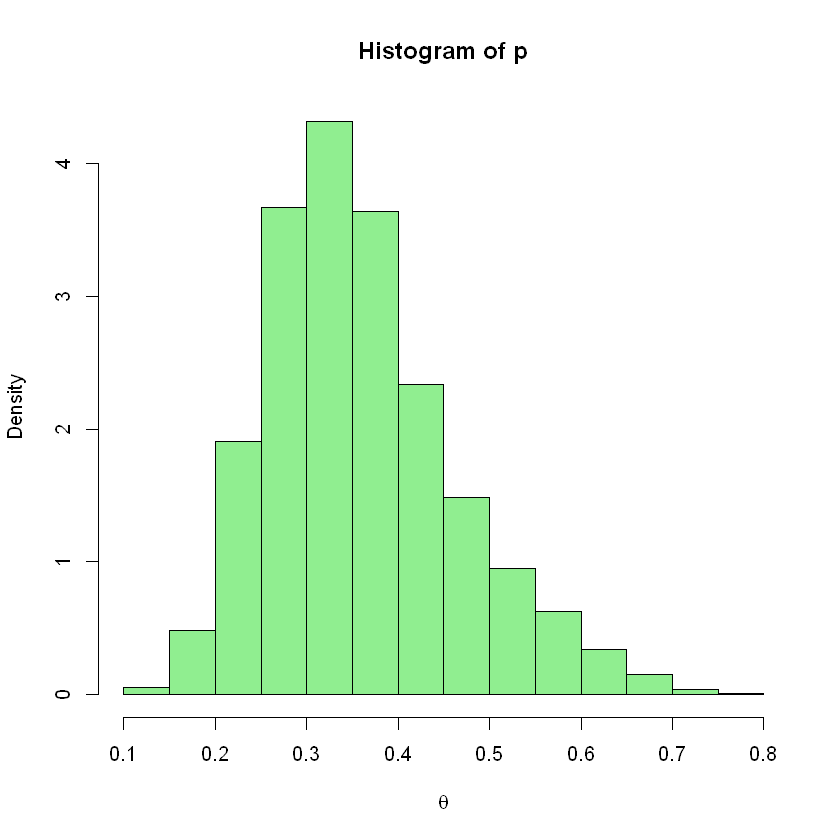

In [46]:
#Extract p:
p <- extract(stanFit, 'p')
p <- unlist(p, use.names=FALSE)

options(repr.plot.width=7,repr.plot.height=7)
#Histogram of the simulated distribution via Stan:
hist(p, freq=FALSE,col="LightGreen",xlab=expression(theta))

#### predictive posterior pmf

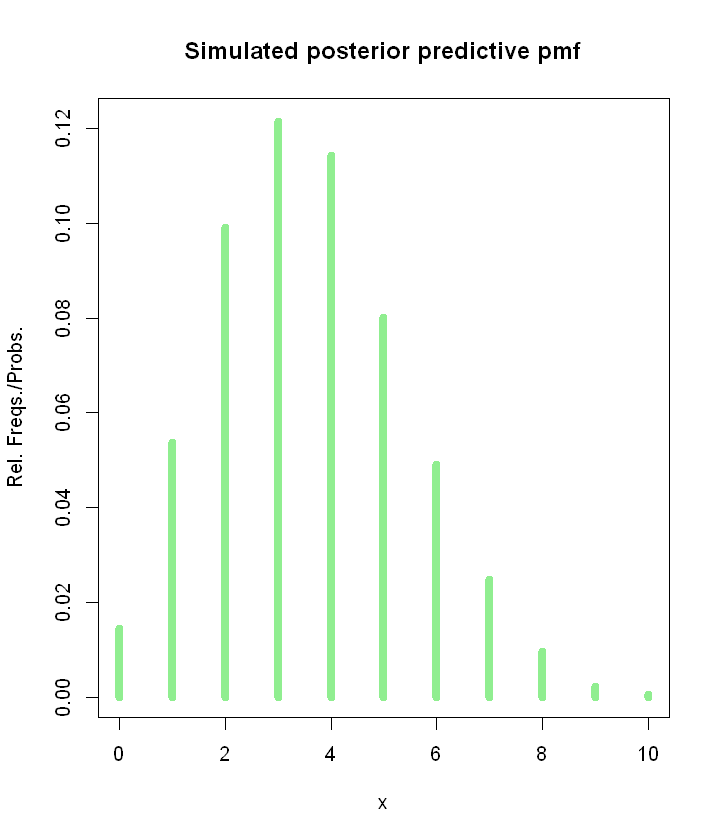

In [47]:
#Extract p:
x_pred <- extract(stanFit, 'x_pred')
x_pred <- unlist(x_pred, use.names=FALSE)

#Calculate as before counts and frequencies of the simulated distribution:
T.x_pred <- table(x_pred)
f.x_pred <- T.x_pred/N
options(repr.plot.width=6,repr.plot.height=7)
v <- names(T.x_pred)
matplot(x=v,y=f.x_pred,type="h",lwd=7, lty=1,col="LightGreen",xlab="x",ylab="Rel. Freqs./Probs.",
        main="Simulated posterior predictive pmf")

In [48]:
color_scheme_set("green")
options(repr.plot.width=15,repr.plot.height=5)
mcmc_hist(stanFit, pars = c("p","theta[1]","theta[2]", "theta[3]"),binwidth=0.05)

ERROR: Error in color_scheme_set("green"): no se pudo encontrar la función "color_scheme_set"
